In [106]:
import numpy as np 
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime

In [19]:
gpus = tf.config.list_physical_devices('GPU')
print(f"detected {len(gpus)} gpus")

detected 1 gpus


### settings

In [20]:
LABELS = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

EPOCHS = 40
LR = 0.0001
IMAGE_SIZE = (512,512,3)
BATCH_SIZE = 16

In [21]:
dataset = tfds.load("oxford_flowers102")
train_dataset = dataset["test"] 
test_dataset = dataset["train"]
val_dataset = dataset["validation"]

### Dataset utils

In [27]:
def preprocess_data(sample): 
    """
        Simply return the image and the label
    """
    
    image =  tf.image.resize(sample["image"],IMAGE_SIZE[:2])
    print(image.shape)
    label = sample["label"]
    
    return image, label


def display_grids(data):
    """
        Argument: 
            data : a batched dataset
    """
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1): 
        for i in range(9): 
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(LABELS[int(labels[i])])
            plt.axis("off")
    
    plt.show()
    

### quickly exploring the dataset : we will have to resize each image to a commin image size

In [23]:
for sample in train_dataset.take(2): 
    print(sample["image"].shape)

(542, 500, 3)
(748, 500, 3)


In [24]:
train_dataset = train_dataset.map(preprocess_data) 
test_dataset = test_dataset.map(preprocess_data) 
val_dataset = val_dataset.map(preprocess_data)

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


In [25]:
for image, label in train_dataset.take(2): 
    print(image.shape)

(512, 512, 3)
(512, 512, 3)


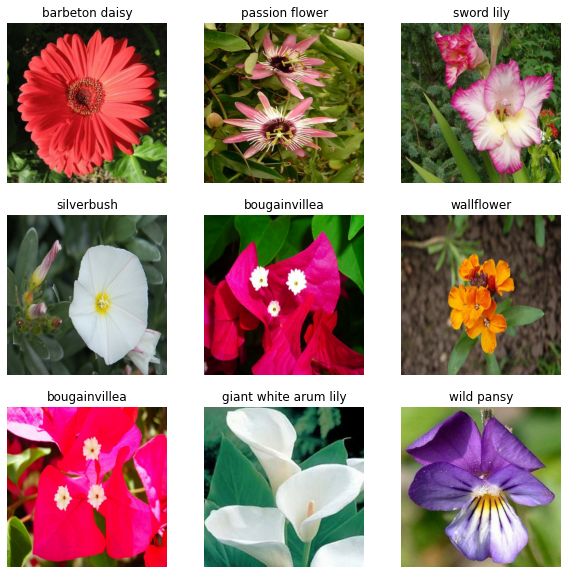

In [28]:
display_grids(train_dataset.batch(BATCH_SIZE))

### Transfer learning

#### We will use the Xception pretrained model, and will fine-tune it to get maximum performance on our dataset


### Let's define a data augmentation pipeline

In [93]:
def data_augm(input_shape=IMAGE_SIZE): 
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
    outputs = tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[outputs])
    

In [94]:
def get_xception(image_size=IMAGE_SIZE): 
    
    model = tf.keras.applications.Xception(
        include_top=False, 
        input_shape=image_size, 
        classes=len(LABELS)
    )
    
    model.trainable = False
    
    return model

In [95]:
xception_model = get_xception()

#### Xception topology

In [96]:
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_45[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

#### Custom top layers

In [109]:
def build_model(input_shape=IMAGE_SIZE): 
    
    inputs = tf.keras.Input(shape=input_shape)
    
    xception_model = get_xception()
    data_augm_pipeline = data_augm(input_shape)
    
    x = data_augm_pipeline(inputs)
    x = tf.keras.applications.xception.preprocess_input(x) 
    
    x = xception_model(x) 
    
    x = tf.keras.layers.Conv2D(256, 1, strides=2,padding="valid", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=1,padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, 1, strides=1,padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(len(LABELS))(x)
    outputs = tf.keras.activations.sigmoid(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model
    
    

In [110]:
model = build_model()
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
model_13 (Functional)        (None, 512, 512, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 512, 512, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 512, 512, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 8, 8, 256)         524544    
_________________________________________________________________
batch_normalization_112 (Bat (None, 8, 8, 256)         102

### model training

In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE) 
val_dataset = val_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [111]:
log_dir = f"logs/fit/xception_tl_lr={LR}_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    tensorboard_callback, 
    tf.keras.callbacks.ModelCheckpoint("best_model.h5",save_best_only=True, verbose=1), 
]

In [112]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [113]:
model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=val_dataset
)

Epoch 1/40


/home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


ValueError: in user code:

    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_14: expected shape=(None, 512, 512, 3), found shape=(512, 512, 3)
